In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_settings_v3 import *
from plot_auxiliary import *
from fractal import get_box_count, get_cluster_densities
from planar import create_proximity_graph
from auxiliary import getLinearReg, load_delta_data

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

In [2]:
networks = ['DT', 'Lattice']
attack = 'BtwU'
L = 256
N = L*L
size = {
    #'DT': 65536,
    #'DT': 16384,
    'DT': N,
    #'Lattice': 128
    'Lattice': L
}
param = 'param'

seeds = {
    'DT': 90,
    'Lattice': 0
}

connected = True

In [3]:
l_values = np.array([2**i for i in range(1, int(np.log2(L))+1)])
box_count_dict = {}
rho_values_dict = {}
for i, network in enumerate(networks):

    seed = seeds[network]
    
    g, max_pos, delta_max = load_delta_data(network, size[network], param, attack, seed)
    position = g.vs['position']
    attack_order = g['attack_order']
    
    h = g.copy()
    h.delete_vertices(attack_order[max_pos+1:])
    gcc = h.components(mode='WEAK').giant()
    
    if connected and network == 'DT':
        indices = gcc.vs['oi']
    else:
        indices = attack_order[:max_pos+1]
    
    print('Computing d_B')
    box_count_dict[network] = get_box_count(position, indices)
    
    print('Computing d_f')
    #rho_values = get_cluster_densities(position, indices, l_values, seeds=len(indices))
    rho_values = get_cluster_densities(position, indices, l_values, seeds=500)
    rho_values_dict[network] = [rho_values, l_values]
    
print(box_count_dict)
print(rho_values_dict)

Computing d_B
Computing d_f
Computing d_B
Computing d_f
{'DT': ([1, 4, 10, 22, 46, 84, 146, 241], [256, 128, 64, 32, 16, 8, 4, 2]), 'Lattice': ([1, 4, 8, 16, 32, 52, 103, 201], [256, 128, 64, 32, 16, 8, 4, 2])}
{'DT': [array([0.377     , 0.194625  , 0.1025    , 0.05983594, 0.0314375 ,
       0.01546387, 0.00723035, 0.00316479]), array([  2,   4,   8,  16,  32,  64, 128, 256])], 'Lattice': [array([0.2555    , 0.189625  , 0.1105625 , 0.0591875 , 0.03078516,
       0.01511279, 0.00705981, 0.00312991]), array([  2,   4,   8,  16,  32,  64, 128, 256])]}


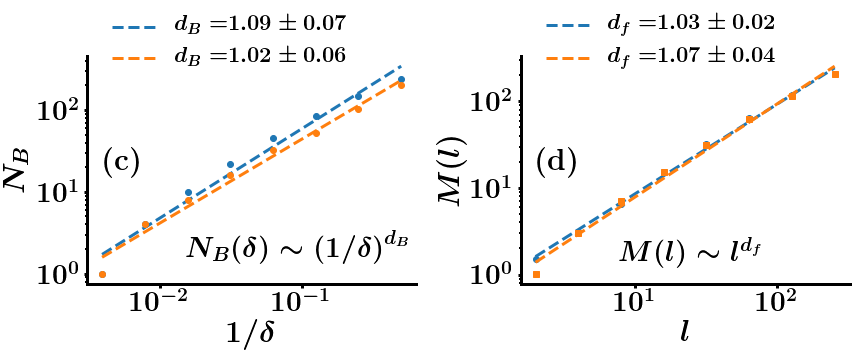

In [4]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols,5*nrows), ncols=ncols, nrows=nrows)
ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/\delta$')
ax.set_ylabel(r'$N_B$')
#ax.text(0.1, 0.8, r'$N_B(\delta) \sim \delta^{-d_B}$', transform=ax.transAxes, fontsize=28)
ax.text(
    0.3, 0.1, r'$N_B(\delta) \sim \left(1/\delta\right)^{d_B}$', 
    transform=ax.transAxes, fontsize=28
)
for i, network in enumerate(networks):
    
    box_count_values, l_values = box_count_dict[network]
    X = 1/np.array(l_values)
    box_count_values = box_count_values
    Y_pred, slope, y_err = getLinearReg(X, box_count_values)
    
    ax.plot(X, box_count_values, 'o', color=colors[i])#, label=network)
    label = r'$d_B = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color=colors[i], label=label)

if connected:
    ax.text(0.05, 0.5, letters[2], transform=ax.transAxes, fontsize=30)
else:
    ax.text(0.05, 0.5, letters[0], transform=ax.transAxes, fontsize=30)
    
ax.legend(loc=(0.05, 0.9), fontsize=22, frameon=False)


ax = axes[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$l$')
#ax.set_ylabel(r'$M(l) / l^2$')
ax.set_ylabel(r'$M(l)$')
#ax.text(0.6, 0.9, r'$M(l) / l^2 \sim l^{d_f-d}$', transform=ax.transAxes, fontsize=28)
ax.text(0.3, 0.1, r'$M(l) \sim l^{d_f}$', transform=ax.transAxes, fontsize=28)
markers = ['o', 's']
for i, network in enumerate(networks):
    
    rho_values, l_values = rho_values_dict[network]
    X = l_values
    Y = [rho*l**2 for (rho, l) in zip(rho_values, l_values)]
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    ax.plot(X, Y, markers[i], color=colors[i])#, label=network)
    label = r'$d_f = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color=colors[i], label=label)

if connected:
    ax.text(0.05, 0.5, letters[3], transform=ax.transAxes, fontsize=30)
else:
    ax.text(0.05, 0.5, letters[1], transform=ax.transAxes, fontsize=30)
    
ax.legend(loc=(0.05, 0.9), fontsize=22, frameon=False)

sns.despine()
plt.tight_layout()
if connected:
    fig_name = os.path.join(fig_dir, 'df_L{}_{}_conn'.format(L, attack))
else:
    fig_name = os.path.join(fig_dir, 'df_L{}_{}'.format(L, attack))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [5]:
network = 'DT'
attack = 'BtwU'
L = 256
N = L*L
seed = 90

g, max_pos, delta_max = load_delta_data(network, N, param, attack, seed)
position = g.vs['position']
attack_order = g['attack_order']

h = g.copy()
h.delete_vertices(attack_order[max_pos+1:])
gcc = h.components(mode='WEAK').giant()

backbone_indices = gcc.vs['oi']

g.delete_vertices(backbone_indices)
#g.delete_vertices(attack_order[:max_pos+1])
gcc = g.components(mode='WEAK').giant()

Ngcc = gcc.vcount()
print(N, Ngcc, Ngcc/N)
gcc.summary()


65536 37733 0.5757598876953125


'IGRAPH U--- 37733 112599 -- \n+ attr: attack_order (g), oi (v), position (v)'